# Procesy Stochastyczne

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import firwin, lfilter

In [2]:
# Set Random seed
np.random.seed(69420)

In [3]:
# Parametry
# Parametr sigma rozkładu Rayleigha
sigma = 1.0
# Częstotliwość próbkowania w Hz
sampling_freq = 10000
# Liczba różnych próbek
sample_sizes = [1000, 5000, 10000, 50000]

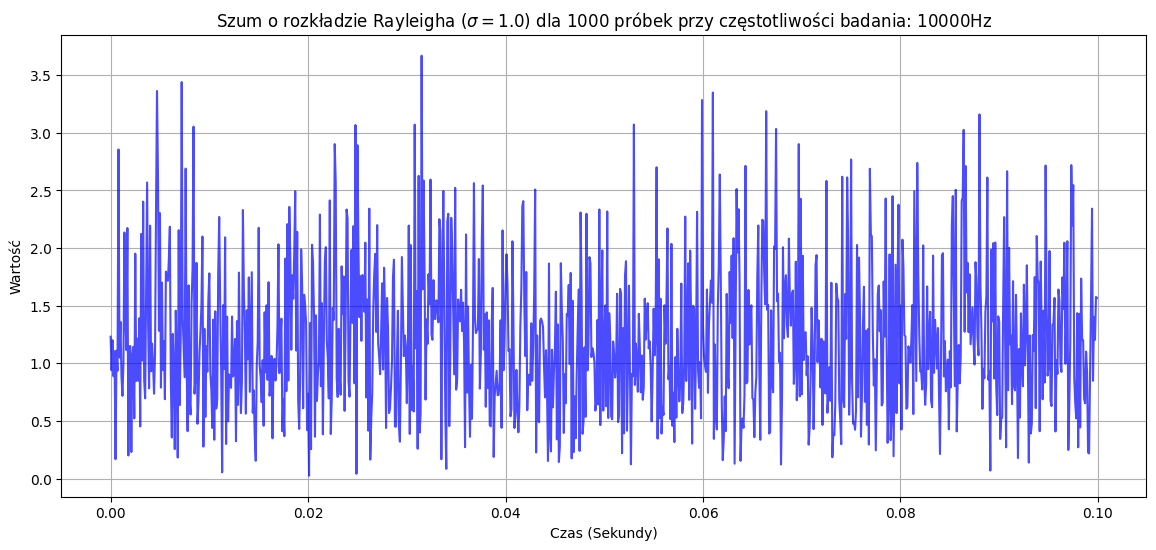

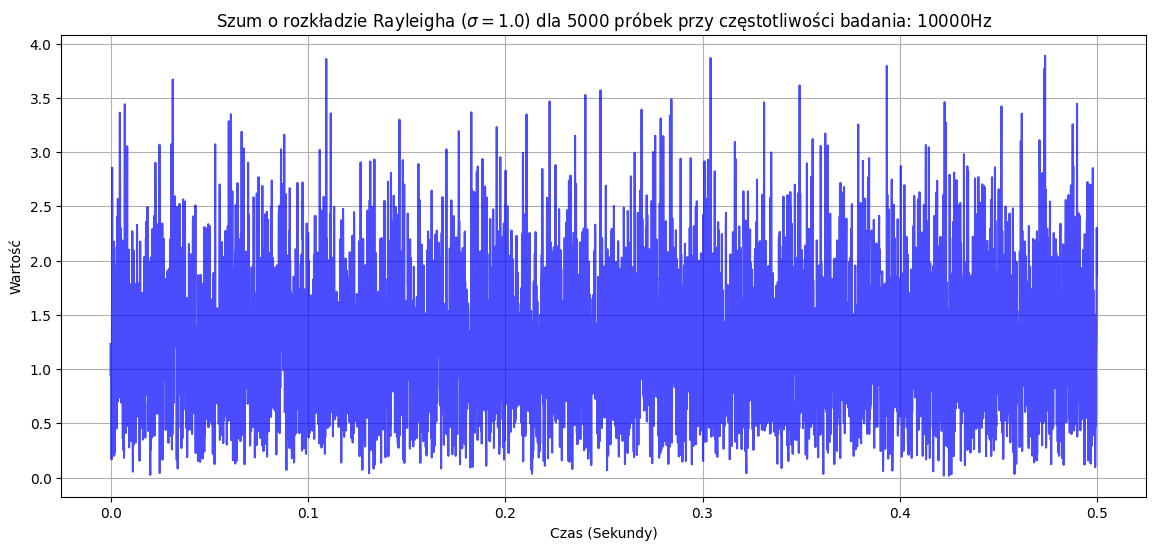

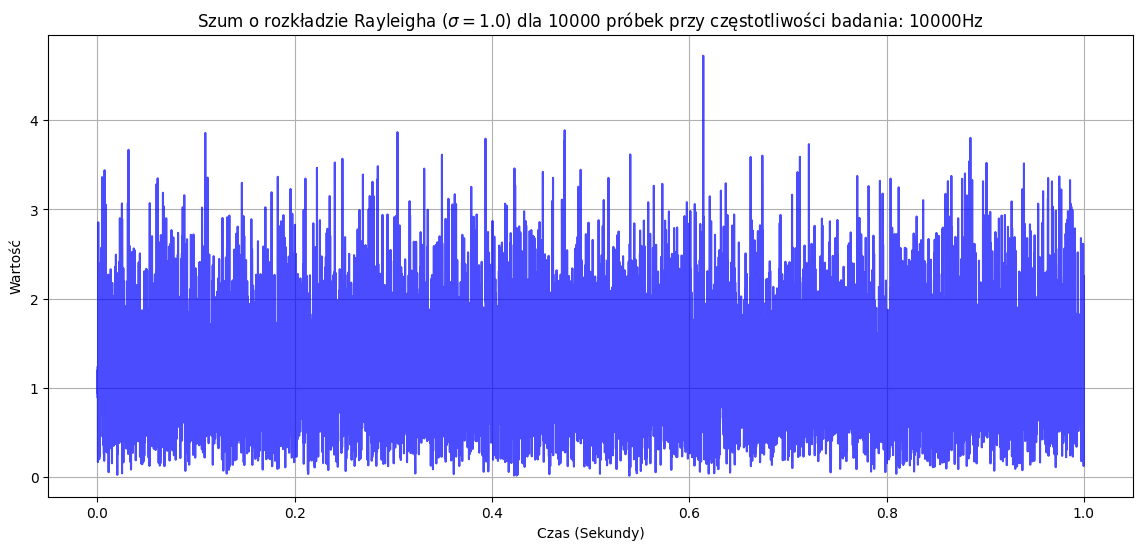

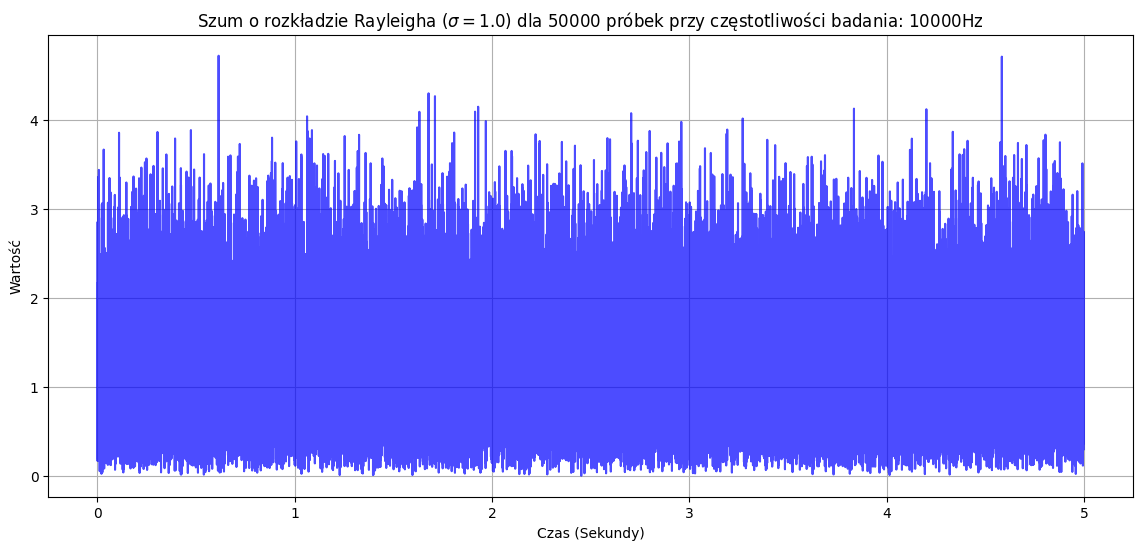

In [4]:
# Obliczenie dodatkowych parametrow
# Liczba wszystkich próbek
num_samples = max(sample_sizes)
# Całkowita długośćtrwania sygnału
duration = num_samples/sampling_freq

# Generowanie szumu
rayleigh_noise = np.random.rayleigh(scale=sigma, size=num_samples)

# Wizualizacja szumu przy różnej ilości próbek
for samples in sample_sizes:
    x_time = np.array([x/num_samples * duration for x in range(samples)])
    plt.figure(figsize=(14, 6))
    plt.plot(x_time, rayleigh_noise[:samples], color="blue", alpha=0.7)
    plt.title(f"Szum o rozkładzie Rayleigha ($\\sigma=1.0$) dla {samples} próbek przy częstotliwości badania: {sampling_freq}Hz")
    plt.xlabel("Czas (Sekundy)", )
    plt.ylabel("Wartość")
    plt.grid(True)
    plt.show()

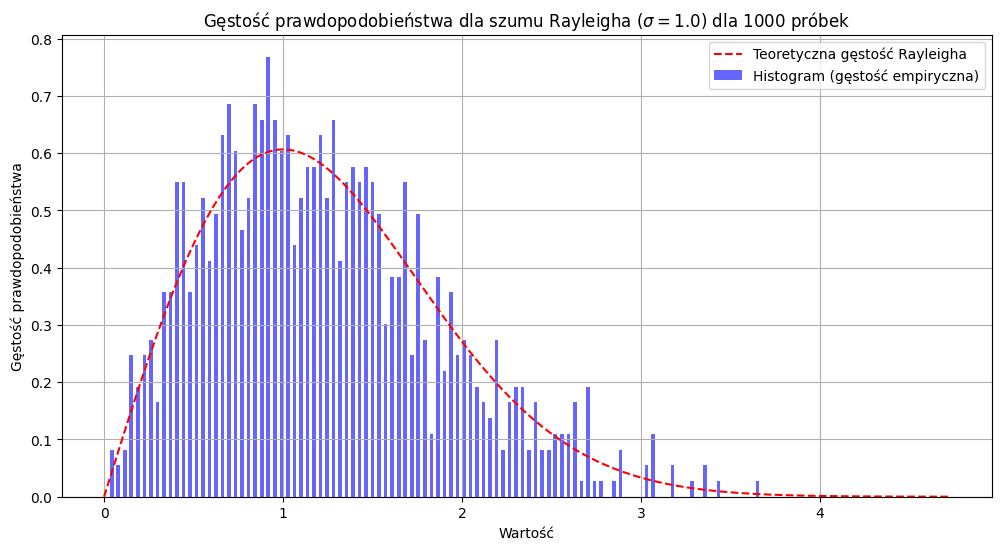

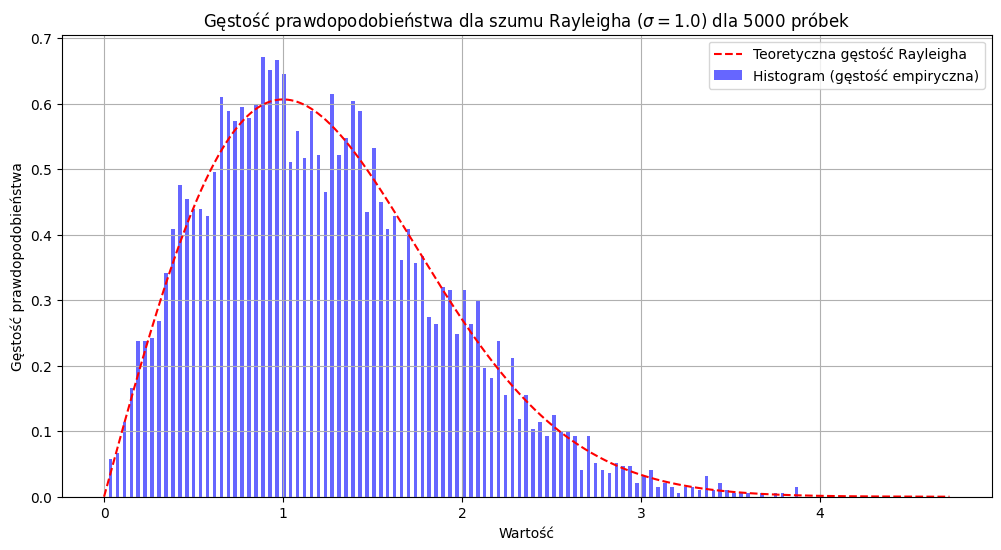

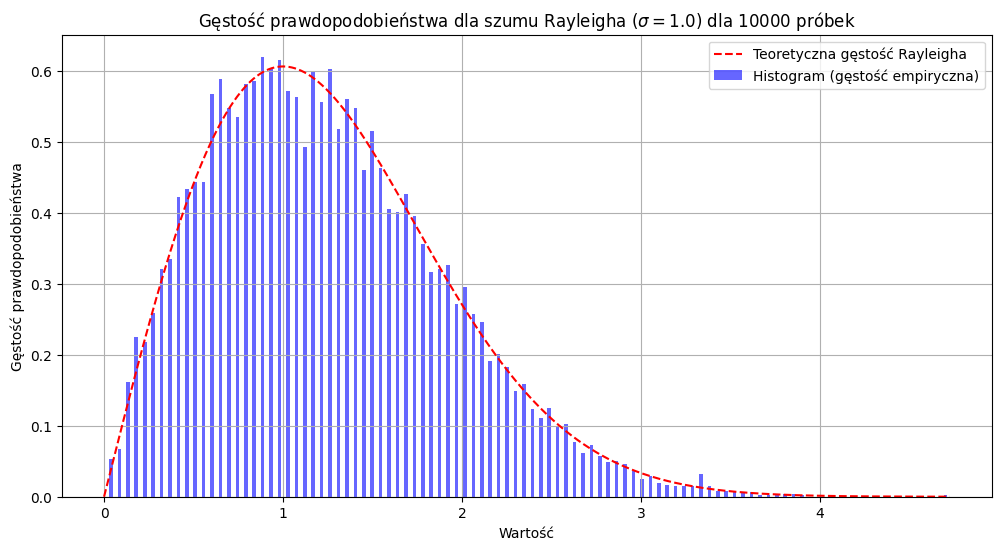

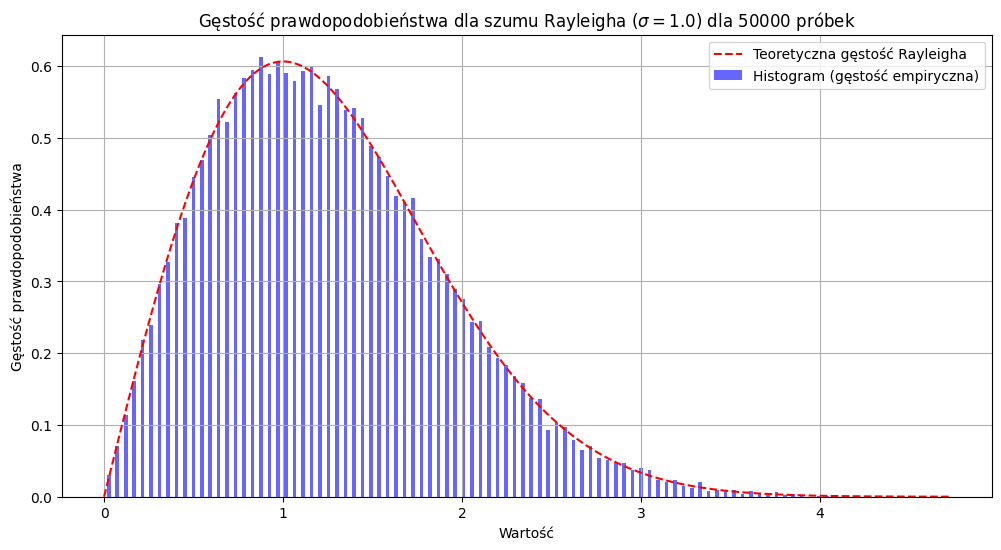

In [5]:
# Wyznaczenie gęstości prawdopodobieństwa (PDF) dla wygenerowanego szumu
pdf_values = []
bins = []
bin_centers = []

x = []
rayleigh_pdf = []

for i in range(len(sample_sizes)):
    pdf_values_d, bins_d = np.histogram(rayleigh_noise[:sample_sizes[i]], bins=100, density=True)
    bin_centers_d = (bins_d[:-1] + bins_d[1:]) / 2  # Środkowe wartości przedziałów
    pdf_values.append(pdf_values_d)
    bins.append(bins_d)
    bin_centers.append(bin_centers_d)

    # Wzorcowa funkcja gęstości prawdopodobieństwa rozkładu Rayleigha dla porównania
    x.append(np.linspace(0, max(rayleigh_noise), sample_sizes[i]))
    rayleigh_pdf.append(stats.rayleigh.pdf(x[i], scale=sigma))

    # Rysowanie histogramu i PDF
    plt.figure(figsize=(12, 6))
    plt.bar(bin_centers[i], pdf_values[i], label="Histogram (gęstość empiryczna)", color="blue", width=0.02, alpha=0.6, )
    plt.plot(x[i], rayleigh_pdf[i], label="Teoretyczna gęstość Rayleigha", color="red", linestyle="--")
    plt.title(f"Gęstość prawdopodobieństwa dla szumu Rayleigha ($\\sigma=1.0$) dla {sample_sizes[i]} próbek")
    plt.xlabel("Wartość")
    plt.ylabel("Gęstość prawdopodobieństwa")
    plt.legend()
    plt.grid(True)
    plt.show()

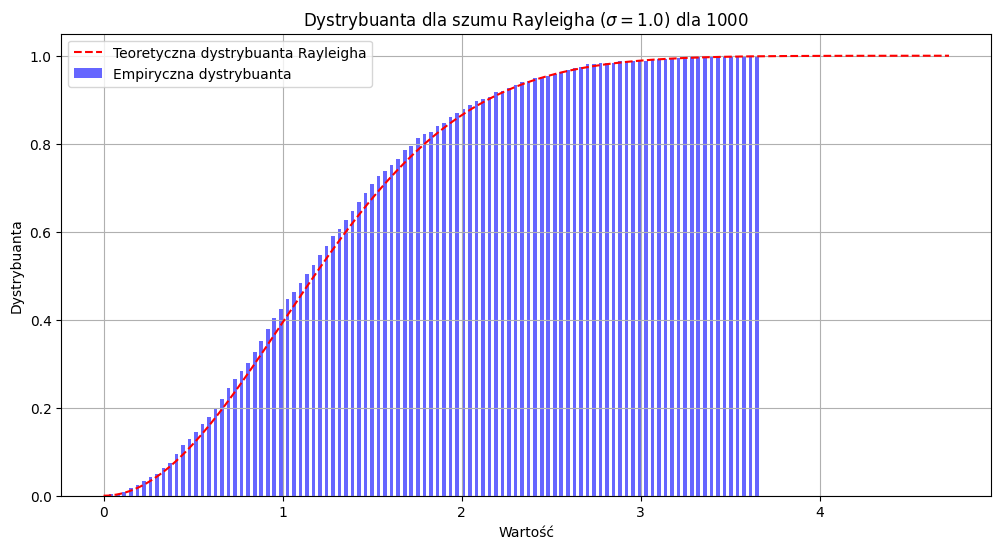

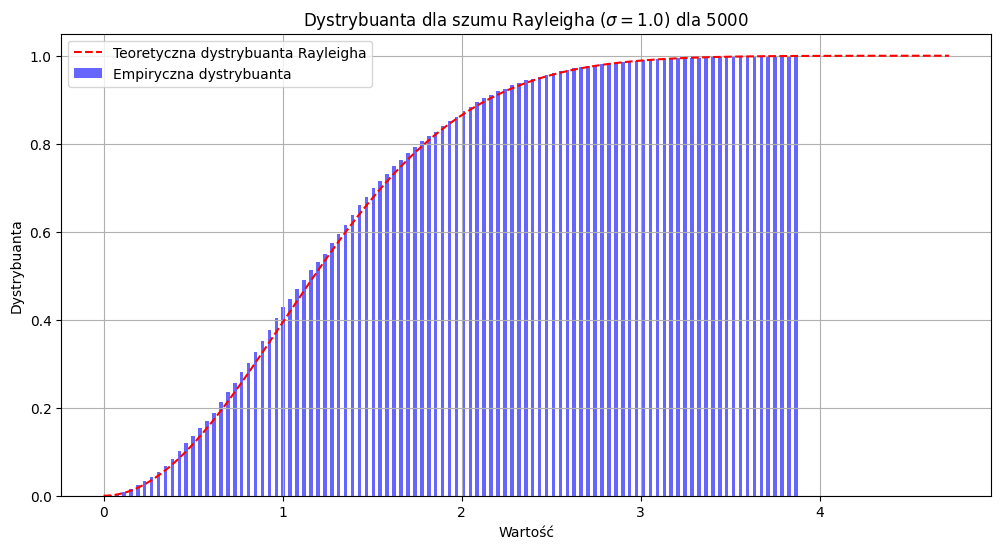

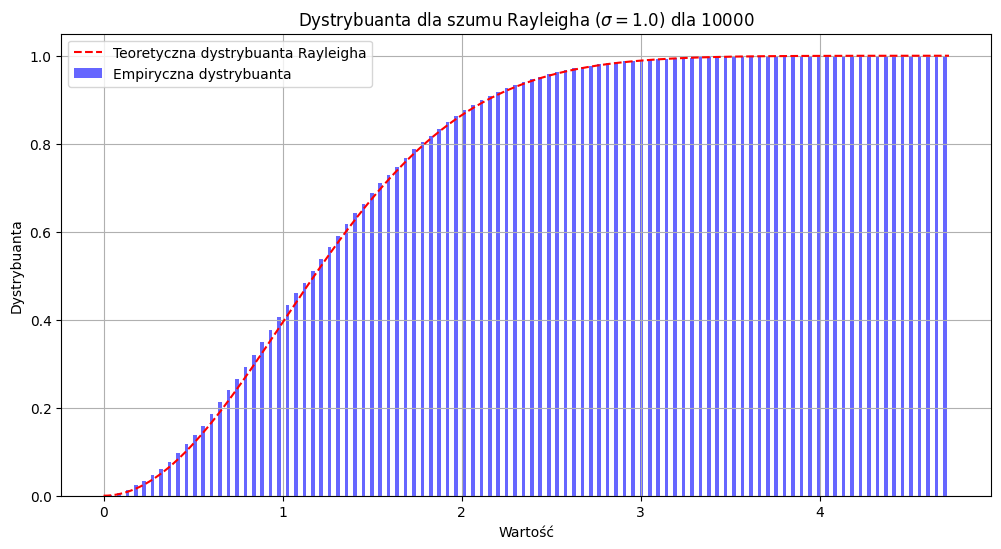

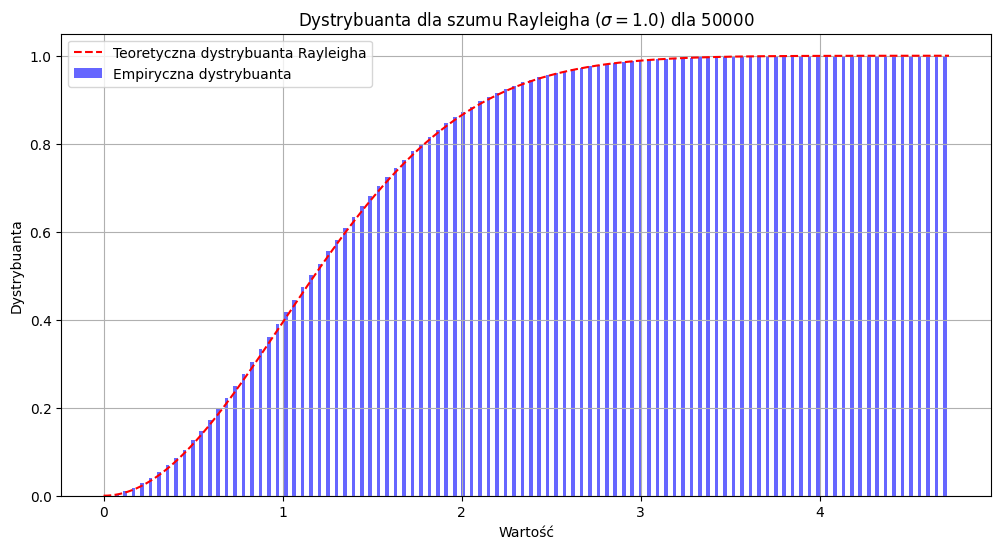

In [6]:
# Obliczanie dystrybuanty (CDF) dla rozkładu Rayleigha na podstawie wygenerowanego szumu
rayleigh_cdf_empirical = []

for i in range(len(sample_sizes)):
    rayleigh_cdf_empirical.append(np.cumsum(pdf_values[i] * np.diff(bins[i])))  # Numeryczna aproksymacja CDF z histogramu

    # Teoretyczna dystrybuanta rozkładu Rayleigha
    rayleigh_cdf_theoretical = stats.rayleigh.cdf(x[i], scale=sigma)

    # Rysowanie dystrybuanty
    plt.figure(figsize=(12, 6))
    plt.bar(bin_centers[i], rayleigh_cdf_empirical[i], label="Empiryczna dystrybuanta", color="blue", width=0.02, alpha=0.6)
    plt.plot(x[i], rayleigh_cdf_theoretical, label="Teoretyczna dystrybuanta Rayleigha", color="red", linestyle="--")
    plt.title(f"Dystrybuanta dla szumu Rayleigha ($\\sigma=1.0$) dla {sample_sizes[i]}")
    plt.xlabel("Wartość")
    plt.ylabel("Dystrybuanta")
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# Obliczenie Wartości Oczekiwanej, Wariancji
# Tabele do obliczeń statystycznych
statistic_tables: list[pd.DataFrame] = []
# Tabela Wyników
summary_table = pd.DataFrame(sample_sizes, columns=['Sample Size'])
summary_table.set_index('Sample Size', inplace = True)
summary_table['Mean/Expected Value'] = 0.0
summary_table['Wariant'] = 0.0
summary_table['Standard Deviation'] = 0.0

# Obliczenie parametrów
for sample_size in sample_sizes:
    table = pd.DataFrame(rayleigh_noise[:sample_size], columns = ['x'])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    summary_table.at[sample_size, 'Mean/Expected Value'] = rayleigh_noise[:sample_size].mean()

    table['x - xsr'] = table['x'] - summary_table.at[sample_size, 'Mean/Expected Value']
    table['(x - xsr)^2'] = table['x - xsr']**2

    summary_table.at[sample_size, 'Wariant'] = (table['(x - xsr)^2'].sum())/(sample_size-1)
    
    statistic_tables.append(table)

summary_table['Standard Deviation'] = summary_table['Wariant']**(1/2)

# Podsumowanie
summary_table

,Mean/Expected Value,Wariant,Standard Deviation
Sample Size,,,
1000,1.224375,0.425301,0.652151
5000,1.236764,0.430649,0.656238
10000,1.244796,0.433730,0.658582
50000,1.255218,0.429222,0.655151


In [8]:
# Obliczenie funkcji kowariancji
# Sumy kowariancji dla poszczególnej liczby próbek:
kowariance_sums = []

# Obliczenie Poszczególnych wyników - Bardzo powolne - niezoptymalizowane.
j_lag = 100
for table in statistic_tables:
    samples = len(table)
    kov_sums_sample = []
    # Stworzenie pustej tabeli
    j_table = pd.DataFrame([[0.0 for i in range(j_lag+1)]for j in range(samples)],
                    columns = [f'f{k}' for k in range(1, j_lag+2)])
    table = table.join(j_table)
    for j in range(j_lag):
        print(f"Table - {samples}: j: {j} / {j_lag}     ", end = '\r')
        samples_n_cov = samples - j
        for i, row in table.iterrows():
            if i >= samples_n_cov:
                break
            table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]
        kov_sums_sample.append(table[f"j{j}"].sum() / samples_n_cov)
    kowariance_sums.append(kov_sums_sample)
    print()         

C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\1551045913.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


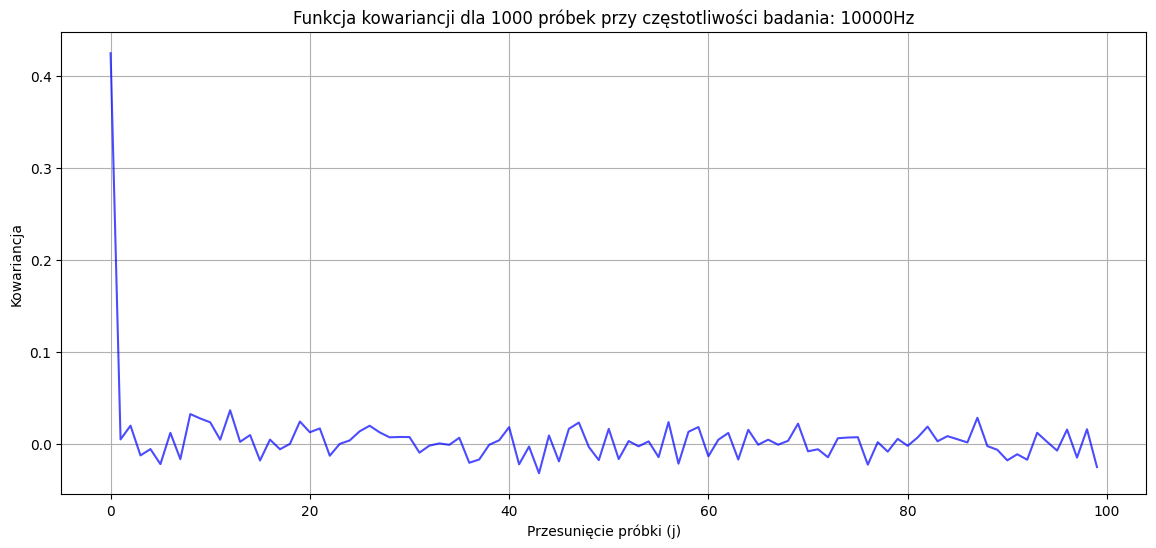

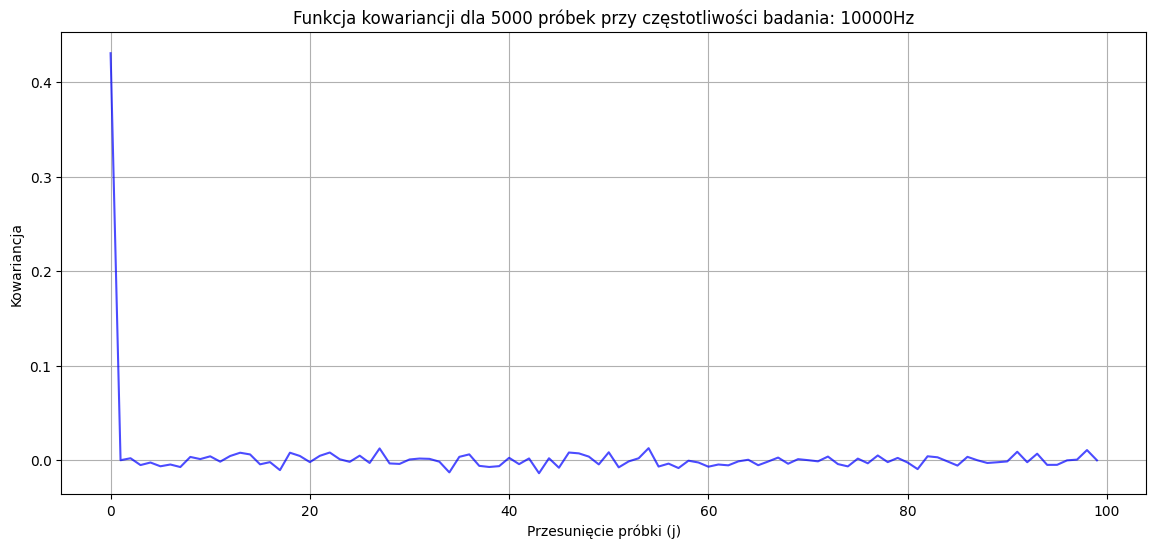

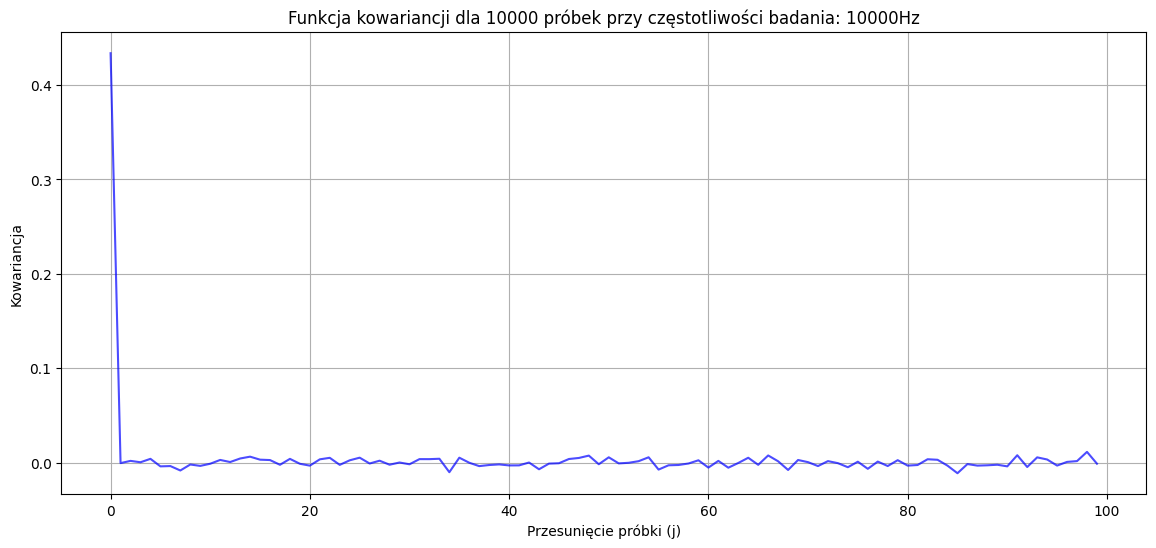

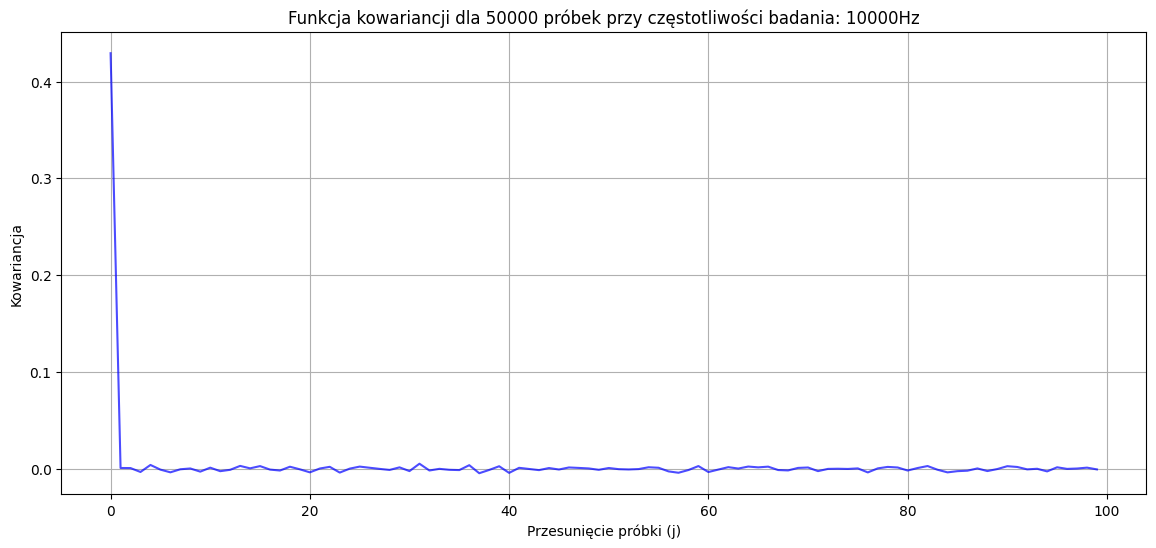

In [9]:
# Rysowanie Funkcji Kowariancji
kowariance_sums_table = pd.DataFrame(kowariance_sums)
kowariance_sums_table = kowariance_sums_table.transpose()

for col in kowariance_sums_table.columns:
    plt.figure(figsize=(14, 6))
    plt.plot(kowariance_sums_table[col], color="blue", alpha=0.7)
    plt.title(f"Funkcja kowariancji dla {sample_sizes[col]} próbek przy częstotliwości badania: {sampling_freq}Hz")
    plt.xlabel("Przesunięcie próbki (j)", )
    plt.ylabel("Kowariancja")
    plt.grid(True)
    plt.show()

In [10]:
# Filtracja Szumu
# Funkcja do projektowania i stosowania filtru FIR
def apply_fir_filter(noise, cutoff_freq, tap_count, fs):
    taps = firwin(tap_count, cutoff_freq, fs=fs, pass_zero="lowpass")
    filtered_signal = lfilter(taps, 1.0, noise)
    return filtered_signal, taps

# Definicje różnych szerokości filtru
filters = [
    {"cutoff_freq": 500, "tap_count": 31},
    {"cutoff_freq": 1000, "tap_count": 51},
    {"cutoff_freq": 2000, "tap_count": 101}
]

# Filtracja sygnału z różnymi filtrami
filtered_signals = []
for filt in filters:
    filtered_signal, taps = apply_fir_filter(rayleigh_noise, filt["cutoff_freq"], filt["tap_count"], num_samples)
    filtered_signals.append(filtered_signal)

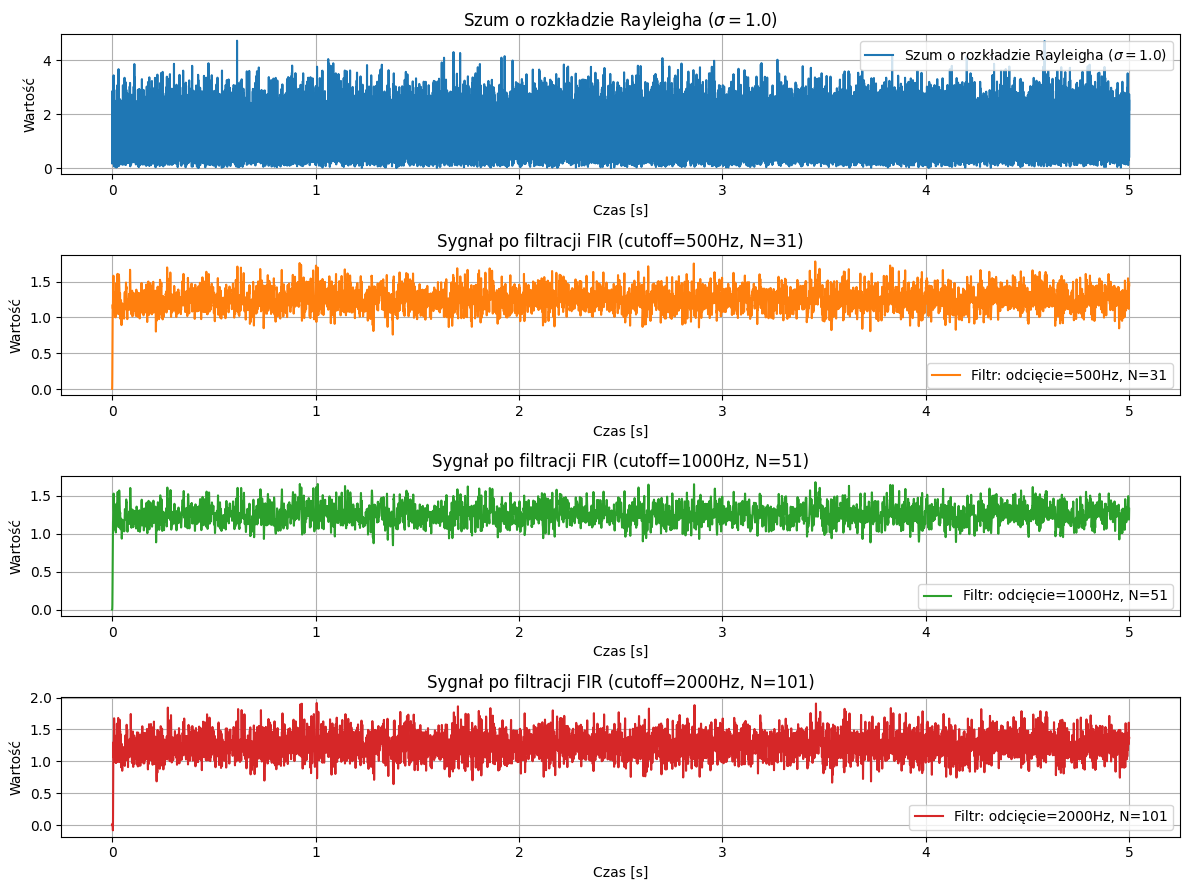

In [11]:
# Wizualizacja
plt.figure(figsize=(12, 9))

# Biały szum
plt.subplot(len(filters) + 1, 1, 1)
plt.plot(x_time, rayleigh_noise, label="Szum o rozkładzie Rayleigha ($\\sigma=1.0$)")
plt.title("Szum o rozkładzie Rayleigha ($\\sigma=1.0$)")
plt.xlabel("Czas [s]")
plt.ylabel("Wartość")
plt.grid()
plt.legend()

# Sygnały po filtracji z różnymi szerokościami filtru
for i, (filtered_signal) in enumerate(filtered_signals):
    plt.subplot(len(filters) + 1, 1, i + 2)
    plt.plot(x_time, filtered_signal, 
             label=f"Filtr: odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']}",
             color=f"C{i+1}")
    plt.title(f"Sygnał po filtracji FIR (cutoff={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Czas [s]")
    plt.ylabel("Wartość")
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

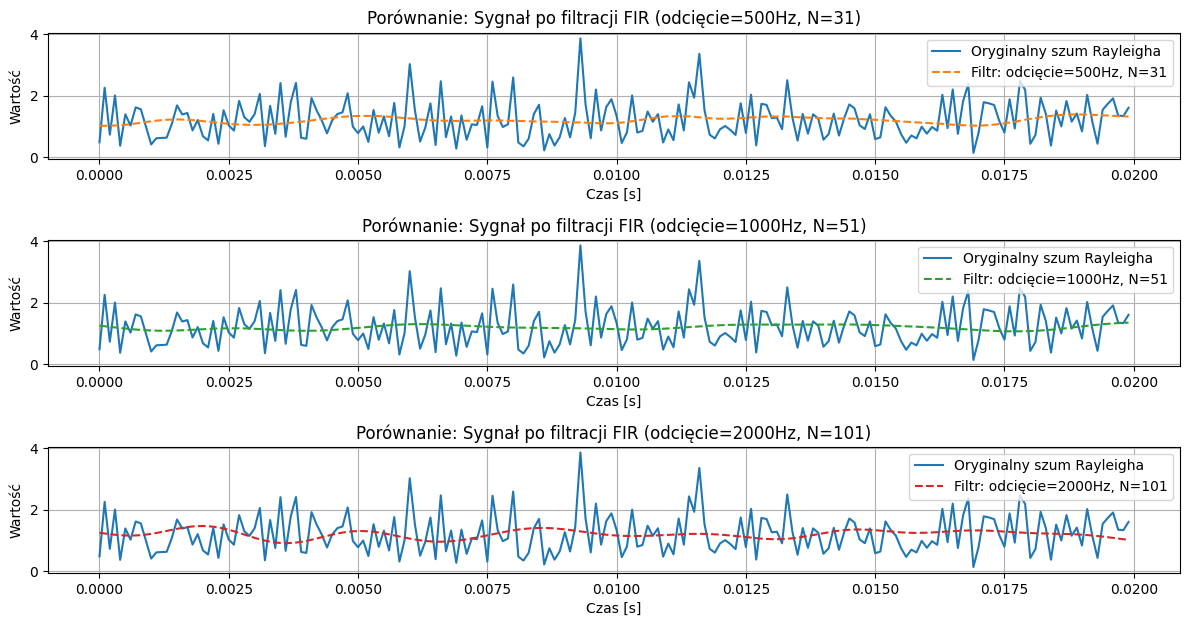

In [12]:
# Wizualizacja - Porownanie z Oryginalem - waski przedział
compare_samples = 200
start_sample = 1000
end_sample = start_sample + compare_samples

plt.figure(figsize=(12, 8))

for i, (filtered_signal) in enumerate(filtered_signals):
    plt.subplot(len(filters)+1, 1, i + 1)
    plt.plot(x_time[:compare_samples], rayleigh_noise[start_sample:end_sample], label="Oryginalny szum Rayleigha")
    plt.plot(x_time[:compare_samples], 
             filtered_signal[start_sample:end_sample], 
             label=f"Filtr: odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']}", 
             color=f"C{i+1}",  
             linestyle='dashed'
             )
    plt.title(f"Porównanie: Sygnał po filtracji FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Czas [s]")
    plt.ylabel("Wartość")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

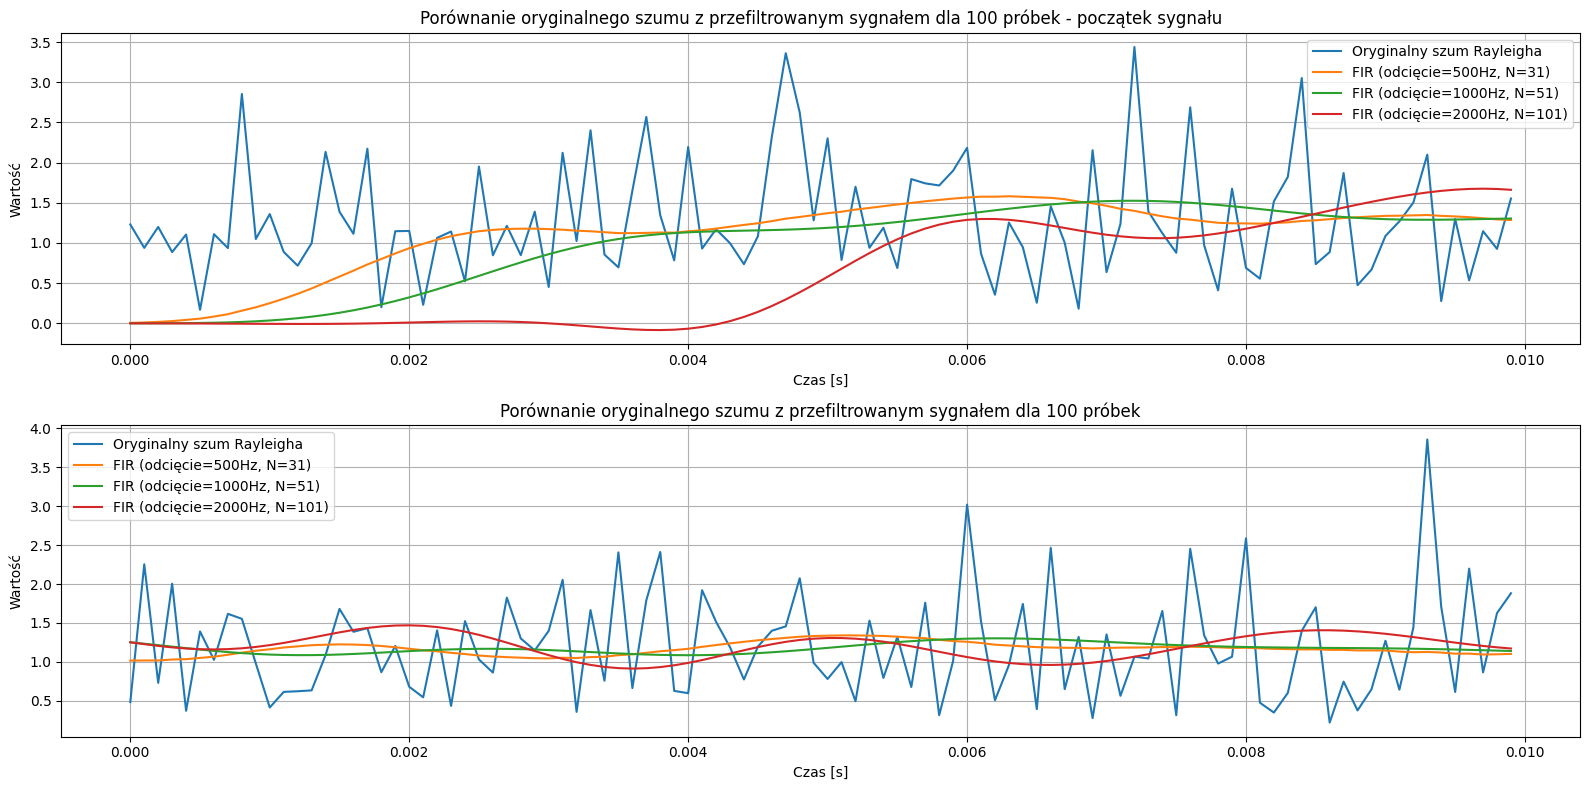

In [13]:
# Wizualizacja - Porownanie z Oryginalem - waski przedział
compare_samples = 100
start_sample = 1000
end_sample = start_sample + compare_samples


plt.figure(figsize=(16, 8))

# Sygnał pierwotny
plt.subplot(2, 1, 1)
plt.plot(x_time[:compare_samples], rayleigh_noise[:compare_samples], label="Oryginalny szum Rayleigha")
for i, filtered_signal in enumerate(filtered_signals):
    plt.plot(x_time[:compare_samples], filtered_signals[i][:compare_samples],
             color=F'C{i+1}',
             label=f"FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
plt.title(f"Porównanie oryginalnego szumu z przefiltrowanym sygnałem dla {compare_samples} próbek - początek sygnału")
plt.xlabel("Czas [s]")
plt.ylabel("Wartość")
plt.legend()
plt.grid()

# Sygnał przefiltrowany
plt.subplot(2, 1, 2)
plt.plot(x_time[:compare_samples], rayleigh_noise[start_sample:end_sample], label="Oryginalny szum Rayleigha")
for i, filtered_signal in enumerate(filtered_signals):
    plt.plot(x_time[:compare_samples], filtered_signals[i][start_sample:end_sample],
             color=F'C{i+1}',
             label=f"FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
plt.title(f"Porównanie oryginalnego szumu z przefiltrowanym sygnałem dla {compare_samples} próbek")
plt.xlabel("Czas [s]")
plt.ylabel("Wartość")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

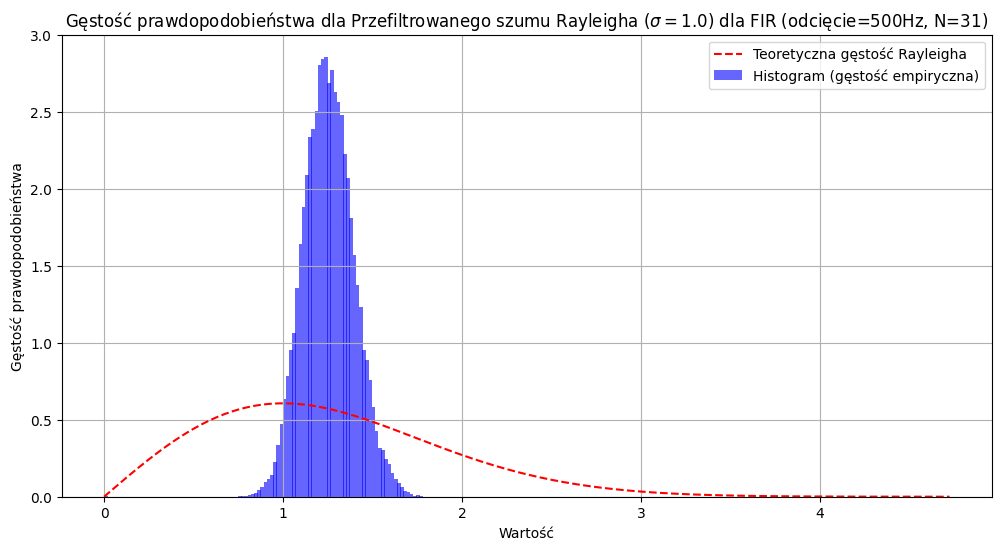

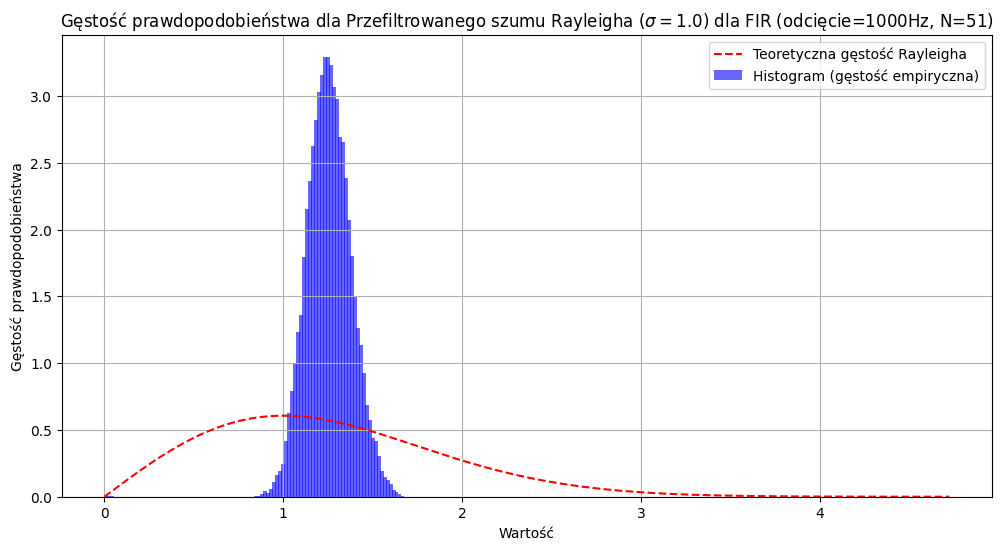

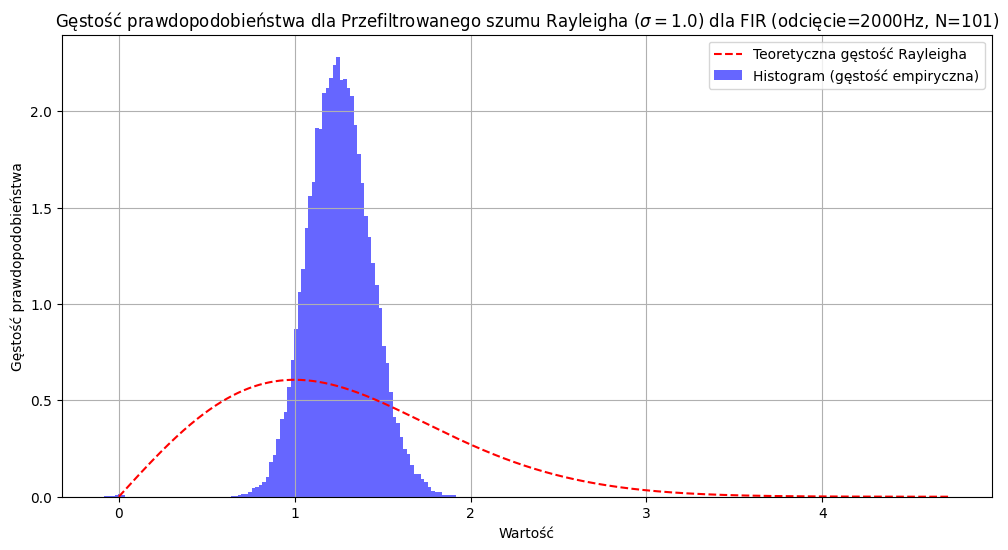

In [14]:
# Wyznaczenie gęstości prawdopodobieństwa (PDF) dla przefiltrowanego szumu
filtered_pdf_values = []
filtered_bins = []
filtered_bin_centers = []

for i, filtered_signal in enumerate(filtered_signals):
    pdf_values_d, bins_d = np.histogram(filtered_signal, bins=100, density=True)
    bin_centers_d = (bins_d[:-1] + bins_d[1:]) / 2  # Środkowe wartości przedziałów
    filtered_pdf_values.append(pdf_values_d)
    filtered_bins.append(bins_d)
    filtered_bin_centers.append(bin_centers_d)

    # Rysowanie histogramu i PDF
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_bin_centers[i], filtered_pdf_values[i], label="Histogram (gęstość empiryczna)", color="blue", width=0.02, alpha=0.6, )
    plt.plot(x[-1], rayleigh_pdf[-1], label="Teoretyczna gęstość Rayleigha", color="red", linestyle="--")
    plt.title(f"Gęstość prawdopodobieństwa dla Przefiltrowanego szumu Rayleigha ($\\sigma=1.0$) dla FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Wartość")
    plt.ylabel("Gęstość prawdopodobieństwa")
    plt.legend()
    plt.grid(True)
    plt.show()

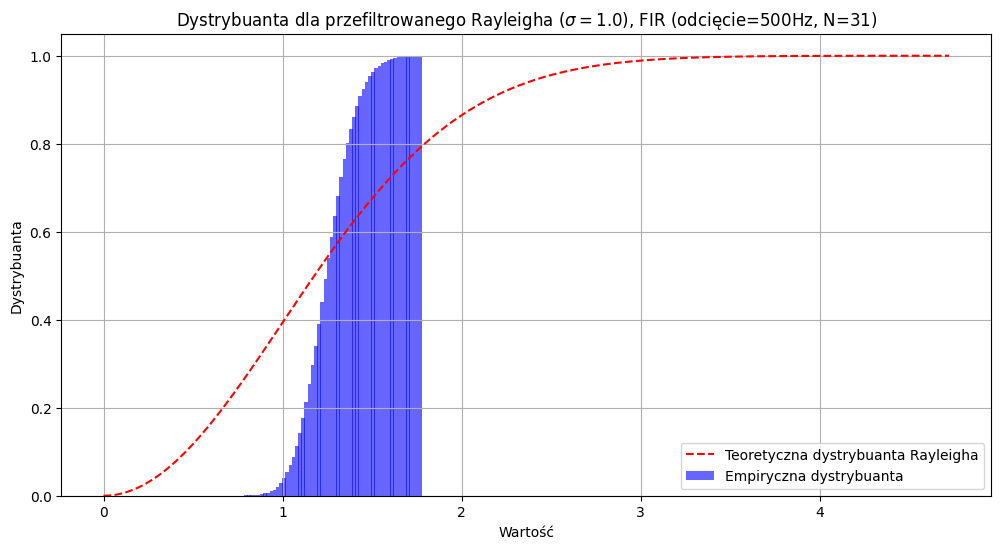

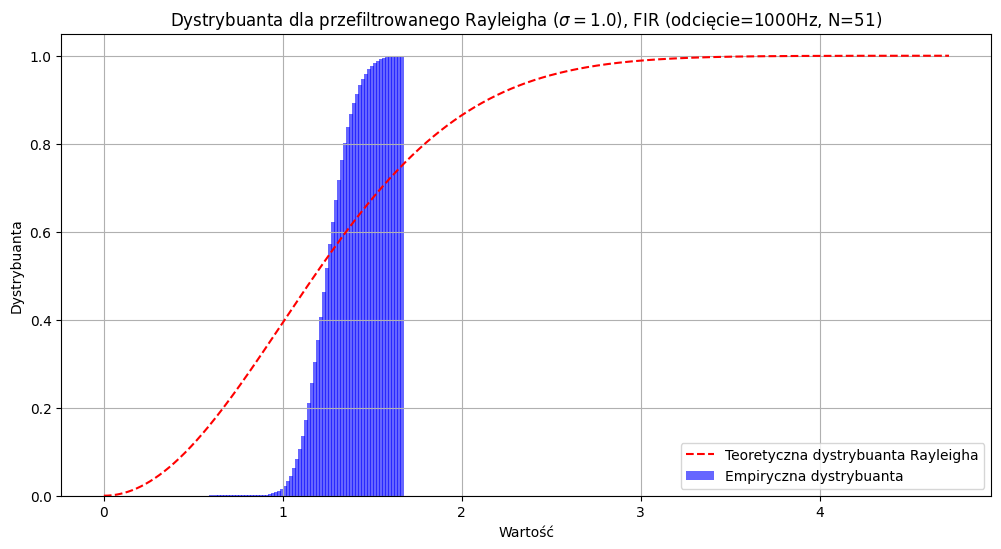

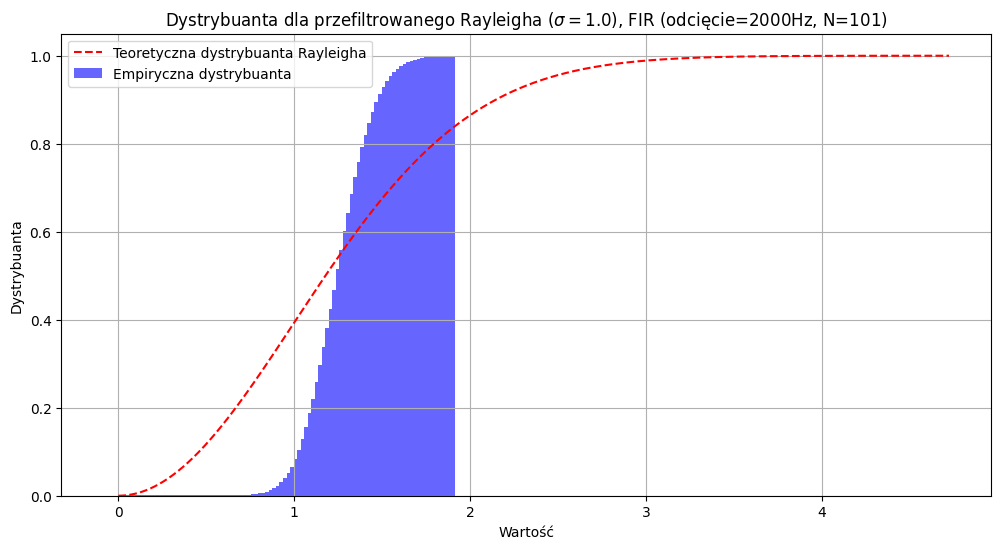

In [15]:
# Obliczanie dystrybuanty (CDF) dla rozkładu Rayleigha na podstawie wygenerowanego szumu
filtered_rayleigh_cdf_empirical = []

for i, filtered_signal in enumerate(filtered_signals):
    filtered_rayleigh_cdf_empirical.append(np.cumsum(filtered_pdf_values[i] * np.diff(filtered_bins[i])))  # Numeryczna aproksymacja CDF z histogramu

    # Teoretyczna dystrybuanta rozkładu Rayleigha
    rayleigh_cdf_theoretical = stats.rayleigh.cdf(x[-1], scale=sigma)

    # Rysowanie dystrybuanty
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_bin_centers[i], filtered_rayleigh_cdf_empirical[i], label="Empiryczna dystrybuanta", color="blue", width=0.02, alpha=0.6)
    plt.plot(x[-1], rayleigh_cdf_theoretical, label="Teoretyczna dystrybuanta Rayleigha", color="red", linestyle="--")
    plt.title(f"Dystrybuanta dla przefiltrowanego Rayleigha ($\\sigma=1.0$), FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Wartość")
    plt.ylabel("Dystrybuanta")
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
# Obliczenie Wartości Oczekiwanej, Wariancji
# Tabele do obliczeń statystycznych
filtered_statistic_tables: list[pd.DataFrame] = []
# Tabela Wyników
used_filters = [
    f"FIR odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']}" for i in range(len(filtered_signals))
]
filtered_summary_table = pd.DataFrame(used_filters, columns=['Filter'])
filtered_summary_table['Mean/Expected Value'] = 0.0
filtered_summary_table['Wariant'] = 0.0
filtered_summary_table['Standard Deviation'] = 0.0

# Obliczenie parametrów
for i, filtered_signal in enumerate(filtered_signals):
    table = pd.DataFrame(filtered_signal, columns = ['x'])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    filtered_summary_table.at[i, 'Mean/Expected Value'] = filtered_signal.mean()

    table['x - xsr'] = table['x'] - filtered_summary_table.at[i, 'Mean/Expected Value']
    table['(x - xsr)^2'] = table['x - xsr']**2

    filtered_summary_table.at[i, 'Wariant'] = (table['(x - xsr)^2'].sum())/(num_samples-1)
    
    filtered_statistic_tables.append(table)

filtered_summary_table['Standard Deviation'] = filtered_summary_table['Wariant']**(1/2)

# Podsumowanie
filtered_summary_table

,Filter,Mean/Expected Value,Wariant,Standard Deviation
0,"FIR odcięcie=500Hz, N=31",1.254803,0.019963,0.141290
1,"FIR odcięcie=1000Hz, N=51",1.254521,0.015349,0.123889
2,"FIR odcięcie=2000Hz, N=101",1.253908,0.032450,0.180138


In [17]:
# Obliczenie funkcji kowariancji
# Sumy kowariancji dla poszczególnej liczby próbek:
filtered_kowariance_sums = []

# Obliczenie Poszczególnych wyników - Bardzo powolne - niezoptymalizowane.
j_lag = 100
for table in filtered_statistic_tables:
    samples = len(table)
    kov_sums_sample = []
    # Stworzenie pustej tabeli
    j_table = pd.DataFrame([[0.0 for i in range(j_lag+1)]for j in range(samples)],
                    columns = [f'f{k}' for k in range(1, j_lag+2)])
    table = table.join(j_table)
    for j in range(j_lag):
        print(f"Table - {samples}: j: {j} / {j_lag}     ", end = '\r')
        samples_n_cov = samples - j
        for i, row in table.iterrows():
            if i >= samples_n_cov:
                break
            table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]
        kov_sums_sample.append(table[f"j{j}"].sum() / samples_n_cov)
    filtered_kowariance_sums.append(kov_sums_sample)
    print()         

C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_16568\3237357828.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


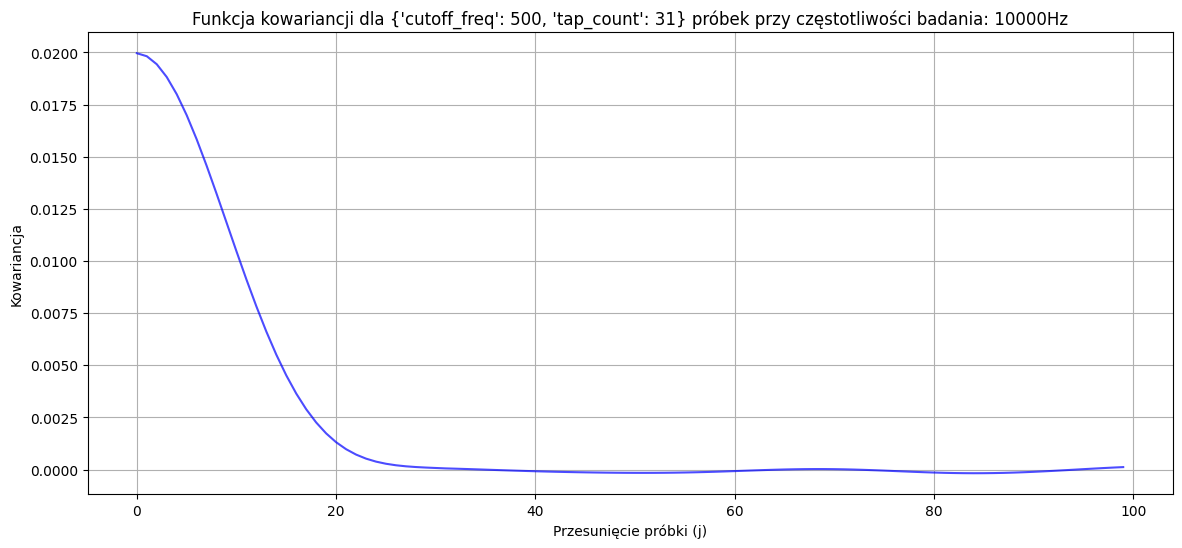

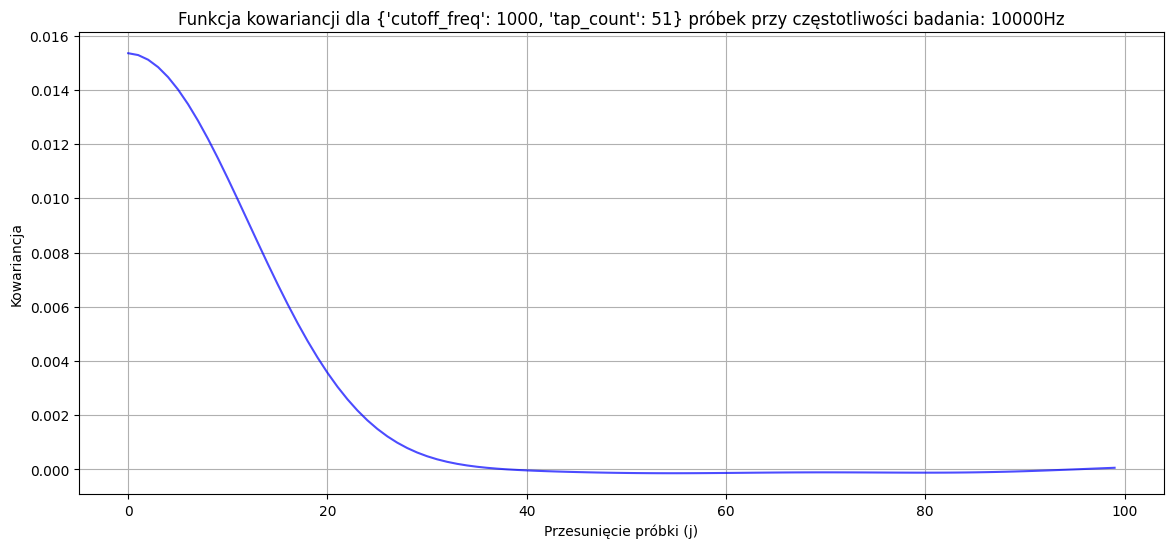

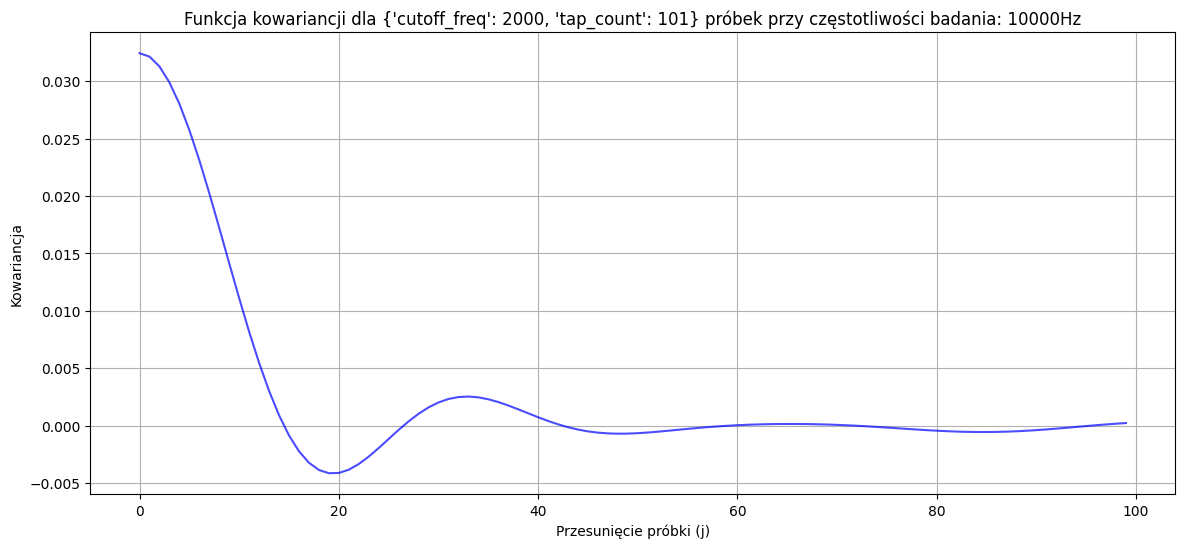

In [21]:
# Rysowanie Funkcji Kowariancji
filtered_kowariance_sums_table = pd.DataFrame(filtered_kowariance_sums)
filtered_kowariance_sums_table = filtered_kowariance_sums_table.transpose()

for col in filtered_kowariance_sums_table.columns:
    plt.figure(figsize=(14, 6))
    plt.plot(filtered_kowariance_sums_table[col], color="blue", alpha=0.7)
    plt.title(f"Funkcja kowariancji dla {filters[col]} próbek przy częstotliwości badania: {sampling_freq}Hz")
    plt.xlabel("Przesunięcie próbki (j)", )
    plt.ylabel("Kowariancja")
    plt.grid(True)
    plt.show()

In [19]:
filtered_kowariance_sums_table

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.424876,0.004899,0.019860,-0.012529,-0.005608,-0.021964,0.012047,-0.016537,0.032453,0.027664,...,-0.017868,-0.011234,-0.017195,0.012082,0.002207,-0.007248,0.015594,-0.014877,0.015967,-0.025137
1,0.430562,0.000137,0.002236,-0.004984,-0.002287,-0.006269,-0.004384,-0.007064,0.003614,0.001352,...,-0.001135,0.009080,-0.001975,0.007032,-0.004782,-0.004733,-0.000005,0.000768,0.010880,0.000030
2,0.433687,-0.000428,0.001930,0.000472,0.004088,-0.003879,-0.003568,-0.008247,-0.001907,-0.003384,...,-0.003882,0.007901,-0.004546,0.005660,0.003391,-0.003059,0.000858,0.001694,0.011451,-0.001060
3,0.429214,0.000964,0.000877,-0.003150,0.004100,-0.000719,-0.003521,-0.000363,0.000465,-0.002801,...,0.002824,0.002019,-0.000462,0.000155,-0.002555,0.001688,0.000040,0.000413,0.001322,-0.000498


In [20]:
kowariance_sums_table

,0,1,2,3
0,0.424876,0.430562,0.433687,0.429214
1,0.004899,0.000137,-0.000428,0.000964
2,0.019860,0.002236,0.001930,0.000877
3,-0.012529,-0.004984,0.000472,-0.003150
4,-0.005608,-0.002287,0.004088,0.004100
...,...,...,...,...
95,-0.007248,-0.004733,-0.003059,0.001688
96,0.015594,-0.000005,0.000858,0.000040
97,-0.014877,0.000768,0.001694,0.000413
98,0.015967,0.010880,0.011451,0.001322


In [76]:
df = pd.DataFrame(['1', '2', '3'], columns = ['x'])

rows = 3
columns = 10

df2 = pd.DataFrame([[0 for i in range(columns)]for j in range(rows)],
                    columns = [f'f{k}' for k in range(columns)])

df = df.join(df2)


3

In [22]:
import numpy as np

# Parametry
sigma = 1.0  # Odchylenie standardowe składników Gaussowskich
size = 1000  # Liczba próbek

# Generowanie dwóch niezależnych zmiennych Gaussowskich
X = np.random.normal(0, sigma, size)
Y = np.random.normal(0, sigma, size)

# Obliczenie amplitudy Rayleigha
R = np.sqrt(X**2 + Y**2)

print(R)  # Tablica próbek z rozkładu Rayleigha


[1.7503689  3.20638252 1.74473044 1.341209   2.44178883 1.21965106
 0.32364504 1.99189174 1.78383346 1.71110708 2.36240522 0.69256318
 1.72014896 0.85807621 0.94124346 2.59294783 1.02828628 2.68998835
 0.54005893 0.7222387  1.28659119 0.89592328 1.01166448 1.86154383
 1.2750093  2.22073774 0.88404151 1.8581626  0.8842933  1.60452181
 1.70528355 0.75536278 0.66299209 0.45721311 2.03020176 2.58046865
 0.43058114 1.79600353 1.52137435 1.09699465 1.51094327 1.91455655
 1.87980082 1.81954867 2.00581356 2.88698223 1.28957846 2.92581569
 1.62083189 0.88632979 1.0197764  1.89120952 0.66134821 1.7343341
 0.81854653 0.99212134 2.06967473 1.71125375 0.46648612 1.04231061
 1.23319586 0.81151473 1.99146101 1.35650121 1.29031412 0.88008811
 1.0819764  1.30009227 2.10661991 1.3008186  0.88683291 1.32951248
 1.7206997  0.45146282 1.23033815 0.38299894 3.04910335 0.85752263
 0.96265576 0.17553767 0.61859935 0.85904951 0.28156842 0.85956912
 2.57299562 1.8047916  1.29207611 0.93282135 1.42732614 0.95819

In [24]:
for i in range (len(X)):
    print(X[i], Y[i], R[i])

1.2723743295971208 1.2020211588985898 1.7503689042763617
2.5662805151667816 1.922262508555309 3.2063825152844805
-0.3715777482154462 1.7047035790885252 1.7447304420815524
-0.7760209082804558 -1.0939072713789526 1.3412089950727921
-1.892051896385321 -1.5435259331227087 2.4417888288788645
-0.7459704831515526 0.9649231762104787 1.2196510557210531
-0.27260068801901405 -0.17445622983763204 0.3236450389510096
-1.9744493744175162 -0.26302539105747946 1.9918917361339348
0.9075110430729424 1.535736152793579 1.7838334631620079
-1.6752690017099325 -0.348369344274991 1.711107076754924
2.312527874410186 0.4828801426925988 2.3624052154808064
-0.6521647742147241 0.23307695194188638 0.6925631799720965
1.5526652513198616 0.7403668373702925 1.720148957658568
0.5821628165301254 -0.6303818240635854 0.8580762140159938
-0.573134064087835 -0.7466301547166397 0.9412434559400835
0.48215415605132644 2.5477256164299487 2.592947829558267
-1.021931806063512 0.11414050323693341 1.02828627858365
-2.688719878900228 -